In [103]:
import nltk
from nltk.corpus import brown

In [104]:
nltk.download("brown")
nltk.download("universal_tagset")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [105]:
corpus = brown.tagged_sents(tagset="universal")

In [106]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [107]:
len(corpus)

57340

In [108]:
inputs = []
targets = []

for sentence_tag_pairs in corpus:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  inputs.append(tokens)
  targets.append(target)

In [109]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional, LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model 
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [110]:
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, test_size=0.33)

In [111]:
MAX_VOCAB_SIZE = None
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=False,
    oov_token="UNK"
)

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [112]:
word2idx = word_tokenizer.word_index
V = len(word2idx)
print(f"Found {V} unique tokens.")

Found 46449 unique tokens.


In [113]:
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [114]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [115]:
all_test_targets = set(flatten(test_targets))
all_test_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [116]:
all_train_targets == all_test_targets

True

In [117]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

In [118]:
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [119]:
T = max(max(len(sent) for sent in train_targets), max(len(sent) for sent in test_targets))
T

180

In [120]:
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print(f"Shape of data train tensor: {train_inputs_int.shape}")

Shape of data train tensor: (38417, 180)


In [121]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print(f"Shape of data test tensor: {test_inputs_int.shape}")

Shape of data test tensor: (18923, 180)


In [122]:
train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print(f"Shape of train targets tensor: {train_targets_int.shape}")

Shape of train targets tensor: (38417, 180)


In [123]:
test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print(f"Shape of test targets tensor: {test_targets_int.shape}")

Shape of test targets tensor: (18923, 180)


In [124]:
K = len(tag_tokenizer.word_index) + 1
K

13

In [125]:
D = 32

i = Input(shape=(T,))
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [126]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

ft = model.fit(
    train_inputs_int, train_targets_int,
    epochs=5,
    validation_data=(test_inputs_int, test_targets_int)
)

Epoch 1/5
1201/1201 [==============================] - 282s 226ms/step - loss: 0.0549 - accuracy: 0.8543 - val_loss: 0.0132 - val_accuracy: 0.9628
Epoch 2/5
1201/1201 [==============================] - 269s 224ms/step - loss: 0.0084 - accuracy: 0.9769 - val_loss: 0.0106 - val_accuracy: 0.9696
Epoch 3/5
1201/1201 [==============================] - 271s 226ms/step - loss: 0.0052 - accuracy: 0.9853 - val_loss: 0.0105 - val_accuracy: 0.9708
Epoch 4/5
1201/1201 [==============================] - 266s 222ms/step - loss: 0.0039 - accuracy: 0.9891 - val_loss: 0.0102 - val_accuracy: 0.9722
Epoch 5/5
1201/1201 [==============================] - 272s 226ms/step - loss: 0.0031 - accuracy: 0.9914 - val_loss: 0.0105 - val_accuracy: 0.9720


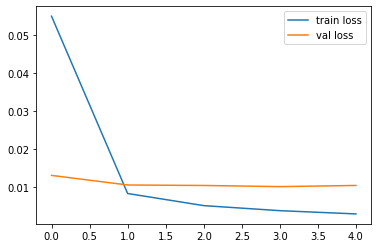

In [127]:
plt.plot(ft.history["loss"], label="train loss")
plt.plot(ft.history["val_loss"], label="val loss")
plt.legend();

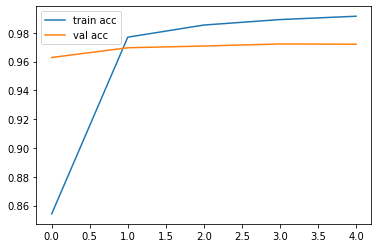

In [128]:
plt.plot(ft.history["accuracy"], label="train acc")
plt.plot(ft.history["val_accuracy"], label="val acc")
plt.legend();

In [129]:
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))



In [130]:
test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))

In [131]:
train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs,length in zip(train_probs, train_lengths):
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

1201/1201 [==============================] - 53s 41ms/step


In [132]:
test_probs = model.predict(test_inputs_int)
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)

592/592 [==============================] - 28s 47ms/step


In [133]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc: ", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc: ", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1: ", f1_score(flat_train_targets, flat_train_predictions, average="macro"))
print("Test f1: ", f1_score(flat_test_targets, flat_test_predictions, average="macro"))

Train acc:  0.9938618610282154
Test acc:  0.9720077472031239
Train f1:  0.9861753468487772
Test f1:  0.927216957059603


In [134]:
from collections import Counter

def most_common(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0]

In [135]:
token2tags = {k: [] for k,v in word2idx.items()}

In [136]:
del token2tags["UNK"]

In [137]:
for tokens,tags in zip(train_inputs, train_targets):
  for token, tag in zip(tokens, tags):
    if token in token2tags:
      token2tags[token].append(tag)

token2tag = {k:most_common(v) for k, v in token2tags.items()}

In [138]:
train_predictions = []
for sentence in train_inputs:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag[token]
    predictions.append(predicted_tag)
  train_predictions.append(predictions)

flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)

In [139]:
test_predictions = []
for sentence in test_inputs:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag.get(token, "INCORRECT")
    predictions.append(predicted_tag)
  test_predictions.append(predictions)

flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)

In [140]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc: ", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc: ", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1: ", f1_score(flat_train_targets, flat_train_predictions, average="macro"))
print("Test f1: ", f1_score(flat_test_targets, flat_test_predictions, average="macro"))

Train acc:  0.9572168115092676
Test acc:  0.9271507102472945
Train f1:  0.9380748933122304
Test f1:  0.8248870658898966
